In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

#%matplotlib notebook
#%matplotlib inline

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
#plt.rcParams['figure.dpi'] = 150

In [2]:
def example():
    
    '''Plots delta function f(t) = delta(t - tau)
    and its Laplace Transform F(s) = exp(-tau*s)
    F(s) = L[f(t)]'''
    tau = 1
    s = np.linspace(0.1, 10, 100)
    F = np.exp(-tau*s)

    def delta(x, pos):
        f = []
        for dx in x:
            if dx == pos:
                f.append(1)
            else: 
                f.append(0)
        return np.asarray(f)

    t = s**-1
    f = np.zeros(1001)
    f = delta(t, tau)
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    ax.set_xlabel('$t$ or $1/s$')
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.plot(t, f, 'r', label = r'f(t)')
    ax.plot(s, F, 'b', label = r'$F(s)=\mathcal{L}\left\{f(t)\right\}$')
    ax.annotate(r'$e^{-\tau t}$',    xy = (2, 0.5),   c='b', fontsize = 13)
    ax.annotate(r'$ \rightarrow $', xy = (3.5, 0.5), c='k', fontsize = 13)
    ax.annotate(r'$\delta(t-\tau)$', xy = (5, 0.5),   c='r', fontsize = 13)
    ax.legend()
#example()

# Inverse the Laplace Transfom using L1 regression methdod

## The point
The point is to determine the decay rate $\tau$ of the exponential function $e^{-\tau s}$ using numerical routines for Inverting the Laplace Transform. For exponential continous function $F(s)$, for $\text{Re}(s) > 0$:
$$F(s) = \sum_{i=0}^{n} \exp{\left(-\tau_i s\right)}$$
$$f(t) = \mathcal{L}^{-1}\left\{F(s)\right \} = \sum_{i=0}^{n} \delta(t - \tau_i)$$

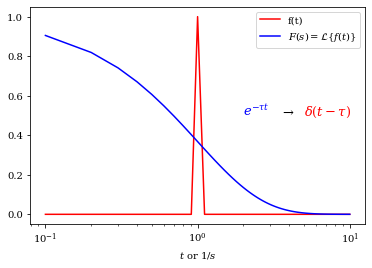

In [3]:
example()

## Numerical Laplace Transform

For this, we replace (1) with finite-difference approximation (2) from <a href="https://sci-hub.st/https://doi.org/10.1137/0730038">[1]</a>:

$$F(s) = \int_0^{\infty} \exp{(-st)}f(t)dt\text{   (1);}$$

$$ \mathbf{Y} = \mathbf{X}\vec{\beta}+\vec\epsilon\text{    (2),}$$

where $\mathbf{X}$ - discrete approximation of Laplace transform;
$\vec\beta$ – elements of spectral function, with length $N_F$;
$\mathbf{Y}$ – given transient vector lenght $N_f$; 
$\vec\epsilon$ – normal noise.

$$\begin{equation*}
\mathbf{X} = \left(
\begin{array}{cccc}
x_{11} & x_{12} & \ldots & x_{1(N_f-1)}\\
x_{21} & x_{22} & \ldots & x_{2(N_f-1)}\\
\vdots & \vdots & \ddots & \vdots\\
x_{(N_F-1)1} & x_{(N_F-1)2} & \ldots & x_{(N_F-1)(N_f-1)}
\end{array}
\right)
\end{equation*}$$

$$x_{ij} = \int_{s_j}^{s_{j+1}}\exp{\left(-s\cdot t_i\right)}ds$$

## The problem

Considering that noise is normal distributed we can maximize the posterior probability and hence minimize the residual sum of squares  

$$\mathbf{Y} = \mathbf{X}\vec{\beta}+\vec\epsilon$$

Since we will fitting the exponential decay with shifted delta function ( $\mathcal{L}\left\{\delta(t-\tau)\right\} = e^{-\tau s}$, for $\text{Re}(s)>0$ ), and in this model weights $\beta_i$ may take zero values. $L_1$ regression can gives us a sparse solution.

$$Q = \left(\mathbf{Y} - \mathbf{X}\vec{\beta}\right)^{T}\cdot\left(\mathbf{Y} - \mathbf{X}\vec{\beta}\right) + \lambda \vec\beta$$
$$\frac{\partial Q}{\partial \beta_i} = -2\mathbf{X}^T\mathbf{Y}+2\mathbf{X}^T\mathbf{X}\vec\beta +\lambda \text{sign}(\beta)$$

## Calculation
### Generating the transient

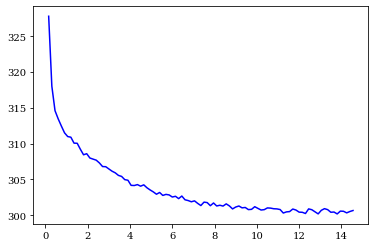

In [4]:
s = np.arange(0.15, 14.7, 0.15) # s domain

tau = [0.3, 8] # decay rates, 1/s

C = 0
C = C + 15*np.exp(-tau[0]*s) + 300
C = C + 45*np.exp(-tau[1]*s)
C = C + np.random.normal(1,1,len(C))*2e-1 # adding noize
fig = plt.figure()
plt.plot(s, C, 'b-')

### Filling $\mathbf{X}$ martix:


In [5]:
tmin = 1E-2 
tlim = 1E2
NF   = len(s)
Nf   = NF # 
t    = tmin*10**(np.linspace(0, 40*np.log10(tlim/tmin), Nf)*0.025) #t domain with exp density points
dt   = np.diff(t)

X    = np.zeros([NF, Nf], dtype = float)
for i in range(NF-1):
        for j in range(Nf-1):
            x1     = -s[i]*(t[j] - dt[j])
            x2     = -s[i]*(t[j] + dt[j])
            X[i,j] = (np.exp(x1) + np.exp(x2))*dt[j]
np.shape(X)

(97, 97)

In [6]:
lmin = 1E-10
llim = 1E1
L = 100
lmbd = np.array([1E-1, 0.5E-1])
#lmbd = lmin*10**(np.linspace(0, 40*np.log10(llim/lmin), L)*0.025)  # reg. parameter values

In [7]:
I = np.identity(Nf)

### Gradient descent

In [8]:
def L1(X, Y, l1):
    costs = []
    beta  = np.random.randn(Nf)/np.sqrt(Nf)
    n     = 50000
    learning_rate = 0.09
    l1     = l1
    for k in range(n):
        Yhat  = X@beta
        delta = Yhat - Y
        beta  = beta - learning_rate*(X.T@delta + l1*np.sign(beta))
        mse   = delta.dot(delta)/NF
        costs.append(mse)
 
    return beta, costs


## Results

In [9]:
l1data = []

fs  = []
costs = []

for dl in lmbd:
    f, cost = L1(X, C  - C[-1], dl) # C - C[-1] – we assume that transient is too long 
    fs.append(f)                    # F(s) = exp(-tau*s) + const
    costs.append(cost)              # F(s->inf) = const
l1data = [fs, costs]                # F(s) - const = exp(-tau*s) = F(s) - F(s)[last index]
l1data = np.asarray(l1data)

### Plotting

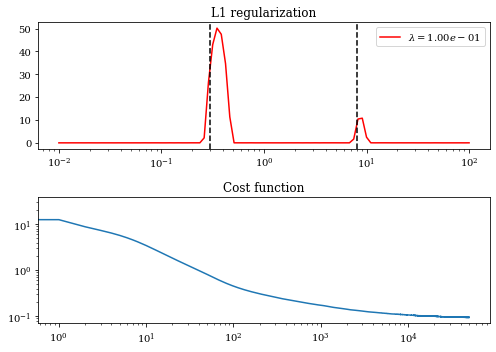

In [10]:
fig = plt.figure(figsize = (7,5))
ax  = fig.add_subplot(211)
ax.set_title('L1 regularization')
ax.set_xscale('log')

l1index = 0

ax.plot(t, l1data[0][l1index], 'r-', label = '$\lambda = %.2e $'%lmbd[l1index])

ax.legend()
az  = fig.add_subplot(212)
az.set_title('Cost function')
az.set_yscale('log')
az.set_xscale('log')
az.plot(l1data[-1][l1index])
for i in tau:
    ax.axvline(x = i, ls = '--', c='k')
plt.tight_layout()

In [11]:
### SVD comparison

In [12]:
def laplace(time, C, bound, Nf, l):
    ######################################
    ######################################

    f_l1, cost = L1(X, C, l)

    ######################################
    ######################################
    from ilt import ilt
    t_svd, f_svd = ilt(time, C, bound, Nf, l)

    fig = plt.figure(figsize = (7,2.5))
    ax  = fig.add_subplot(111)
    ax.set_xscale('log')
    ax.plot(t, f_l1/max(np.abs(f_l1[5:-5])), 'r-', label = 'L1')
    ax.plot(t_svd, f_svd/max(f_svd[5:-5]),    '-', label = 'SVD')
    ax.legend()
    for i in tau:
        ax.axvline(x = i, ls = '--', c='k')
    
    fig = plt.figure(figsize = (7,2.5))
    ay  = fig.add_subplot(111)
    ay.set_title('Cost function')
    ay.set_xscale('log')
    ay.set_yscale('log')
    ay.plot(cost)
    ######################################
    ######################################

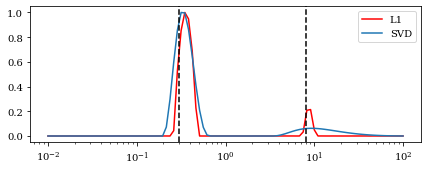

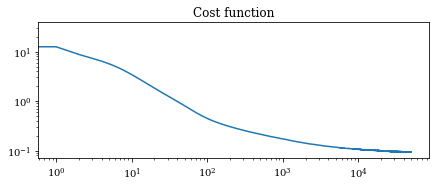

In [13]:
laplace(s, C - C[-1], [1E-2, 1E2], Nf, 1E-1)

### P.S.
SVD routines are working only with same sing exponents amplitudes (only positive singular values). So here SVD is only for comparison of obtained results.

Короче вопросы следующие:

* Можно ли как-нибудь улучшить начальную генерацию весов в перед градиентным спуском, чтобы ускорить работу подгонки?
* Обычно learning rate меняется в процессе обучения или лучше будет оставить его постоянным? Если менять, то как? И какие вообще значения брать?
* Стоит ли попробовать $L_1 + L_2$ регуляризацию, тут это уместно? Если да, то подскажи как выбирать параметр для обоих регуляризаторов?

### Articles

1 <a href="https://sci-hub.st/https://doi.org/10.1137/0730038"> A REGULARIZATION METHOD FOR THE NUMERICAL INVERSION OF THE LAPLACE TRANSFORM. CHEN WEI DONG</a>

2 <a href="https://sci-hub.st/https://doi.org/10.1002/cmr.a.21263"> Laplace Inversion of Low-Resolution NMR Relaxometry Data Using Sparse Representation Methods. PAULA BERMAN ET AL.</a>